<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_07_Training%2C_Evaluating_and_Tuning_Models_(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: In-hospital Mortality Prediction (Cont'd)

# 1. Setting up

**Packages for data handling and visualization**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

**Packages for data analysis and modelling**

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

**Import the intermediate dataset and Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in the previous tutorial, you can grant Colab access to your Google Drive and import the intermediate dataset to the current notebook.

Alternatively, when you are working on your own analysis, you may also put everything (e.g. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case, you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True) # you would need to authenicate yourself here

gdrive_rootpath = '/content/gdrive/MyDrive/' 
# if you saved the file inside a folder in your Google Drive (instead of the base path), 
# you would need to append the folder name to the above

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [6]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,IN_HOSP_DEATH,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


---

# 2. Training, Evaluating and Tuning Models

## 2.1. Train-test Split

We will split the dataset into a training set and a test set with the same codes included in the previous tutorial. 

`IN_HOSP_DEATH` would be our prediction target. Here, let's define a list of 38 column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`). 

In [7]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

 Then, create a DataFrame containing input features only as well as a Series containing our prediction target. 

In [8]:
X = df[features_list]
y = df['IN_HOSP_DEATH']

Finally, use `train_test_split()` from the package [Scikit-learn](https://scikit-learn.org/stable/) to perform a train-test split. 

Note that the function outputs four things: the input and output datasets for training and testing respectively. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [10]:
X_train.shape

(47180, 38)

In [11]:
X_test.shape

(11796, 38)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively. 

---

## 2.2. Training a Random Forest Model

* A Random Forest model consists of multiple Decision Tree models.
* Each decision tree consists of levels of nodes that represent yes/no questions. By following these rules given by a decision tree, each sample arrives to the end node which outputs a prediction. 
* Decision trees are trained by minimizing metrics such as gini score or entropy. 
* Random Forest is trained by first training multiple decision trees with different subsets of the training dataset as inputs; then aggregate the predictions from all decision trees via a majority vote or averaging. 

![Random Forest](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

([Source](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/))

As discussed in the last tutorial, model training in Scikit-learn follows a 3-step process:

1. Specify a model to be trained
  * Choose a type of model based on your task and dataset. A full list of available models in the package can be found [here](https://scikit-learn.org/stable/modules/classes.html).
  * Set the hyperparameters of the model. 
  * Assign the model to a variable.
2. Train the model
  * Call the `.fit()` function using your cleaned train dataset.
3. Make predictions
  * Call the `.predict()` function using your cleaned test dataset.

Define the configuration/hyperparameters of a random forest model. Here we specify that the model contains 200 decision trees.

In [12]:
# 1. Specify a model to be trained
# Also define the configuration/hyperparameters of a random forest model. 
# Here we specify that the model contains 200 decision trees.
model_rf1 = RandomForestClassifier(n_estimators = 200, 
                                   random_state = 1,
                                   n_jobs = -1)

In [13]:
# 2. Train the model
model_rf1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=1)

In [14]:
# 3. Make predictions
y_pred_rf1 = model_rf1.predict(X_test)
y_pred_rf1

array([1, 0, 0, ..., 0, 0, 0])

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs. 

In [15]:
y_pred_prob_rf1 = model_rf1.predict_proba(X_test) 
y_pred_prob_rf1 # the two columns represent the prob of 0 and 1 respectively 

array([[0.15 , 0.85 ],
       [0.975, 0.025],
       [0.985, 0.015],
       ...,
       [0.965, 0.035],
       [0.885, 0.115],
       [0.965, 0.035]])

---

## 2.3. Evaluation

In [16]:
# to calculate accuracy:
accuracy_score(y_test, y_pred_rf1)

0.9379450661241099

In [17]:
# to calculate F1 score:
f1_score(y_test, y_pred_rf1)

0.5896860986547086

In [18]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_rf1, digits = 3))

              precision    recall  f1-score   support

           0      0.942     0.992     0.966     10625
           1      0.858     0.449     0.590      1171

    accuracy                          0.938     11796
   macro avg      0.900     0.721     0.778     11796
weighted avg      0.934     0.938     0.929     11796



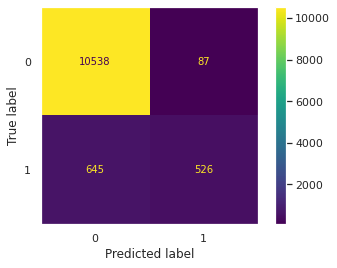

In [19]:
# to visualise a confusion matrix using a heatmap:
ConfusionMatrixDisplay.from_estimator(model_rf1, X_test, y_test)
plt.grid(False) # just to disable grid lines for this plot

Note that the colour in the above plot has little implications as the quantity of the two classes differ by too much. We can express them as ratios and percentages instead. 

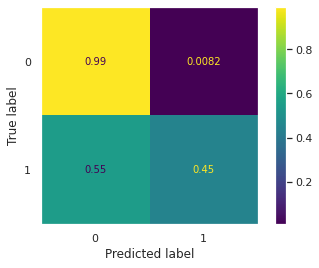

In [20]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_estimator(model_rf1, X_test, y_test, normalize = 'true') 
plt.grid(False)

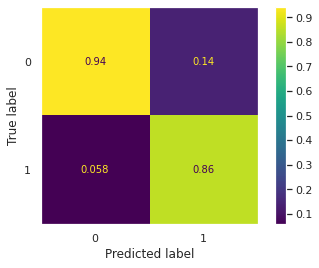

In [21]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_estimator(model_rf1, X_test, y_test, normalize = 'pred')
plt.grid(False)

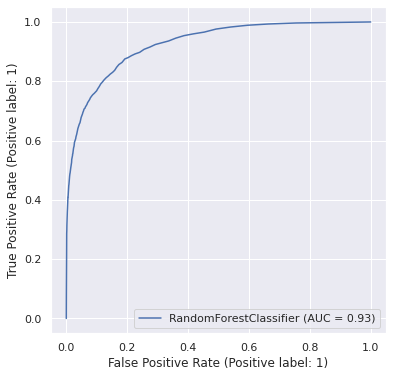

In [22]:
# to plot an ROC:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_rf1, X_test, y_test, ax = ax)

In [23]:
# to calculate Area under ROC:
roc_auc_score(y_test, y_pred_prob_rf1[:,1])

0.9250772090219521

**Some Observations**

* This model outperforms the logistic regression model we have trained last tutorial in several metrics:

|           | Random Forest | Logistic Regression |
|-----------|--------------:|--------------------:|
| Accuracy  |         93.8% |               92.6% |
| F1 Score  |         59.0% |               49.2% |
| Precision |         85.8% |               79.7% |
| Recall    |         44.9% |               35.6% |
| AUC       |         92.5% |               86.2% |

* The recall is still not optimal at 44.9%, meaning that only around half of those who died within their hospital stay is successfully detected by the model. Depending on the objectives of your model, it **could be beneficial to choose another cutoff point** for binary classification predictions rather than the default 0.5. One might prioritise recall over precision if the impact of having false negatives outweighs false positives. For example, for cancer prediction, minimising the risk of unidentified positive cases (hence delayed treatment) could outweigh the inconvenience and costs incurred by additional checkup appointments for negative cases. 

As an example, let's lower the cutoff to 0.2 so that more patients will be classified as positive (hence higher recall at the cost of lower precision). We can use the probablistic outputs from the model (saved in `y_pred_prob_rf1`) and define a new cutoff ourselves. 

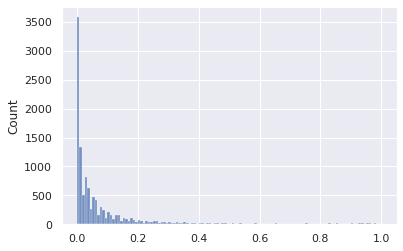

In [24]:
sns.histplot(y_pred_prob_rf1[:,1])

In [25]:
y_pred_rf1_cutoff20 = (y_pred_prob_rf1[:,1] > 0.2) * 1
y_pred_rf1_cutoff20

array([1, 0, 0, ..., 0, 0, 0])

In [26]:
pd.Series(y_pred_rf1).value_counts() # 0.5 as cutoff

0    11183
1      613
dtype: int64

In [27]:
pd.Series(y_pred_rf1_cutoff20).value_counts() # 0.2 as cutoff

0    10201
1     1595
dtype: int64

In [28]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_rf1_cutoff20, digits = 3))

              precision    recall  f1-score   support

           0      0.969     0.930     0.949     10625
           1      0.534     0.728     0.616      1171

    accuracy                          0.910     11796
   macro avg      0.751     0.829     0.783     11796
weighted avg      0.926     0.910     0.916     11796



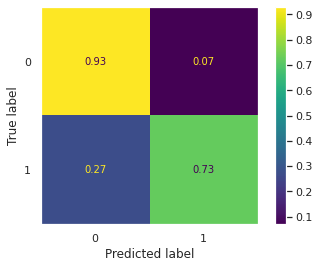

In [29]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf1_cutoff20, normalize = 'true') 
plt.grid(False)

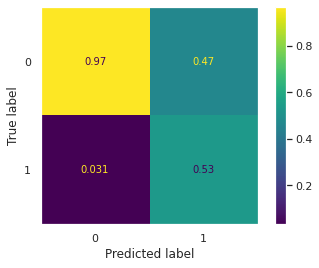

In [30]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf1_cutoff20, normalize = 'pred')
plt.grid(False)

* As we lower the cutoff, more patients were classified as positive (613 -> 1,595), leading to a better recall (44.9% -> 72.8%) and a worse precision (85.8% -> 53.4%)

---

## 2.4. Tuning a Random Forest Model

Hyperparameters are a pre-defined set of configurations of a machine learning model. Examples of that include the number of decision trees as well as the depth of each tree in a random forest model. Although Scikit-learn provides a good set of default values for you to start with, these hyperparameters often need to be tuned for further optimise the model's performance. 

Now, we try to **tune the hyperparameters** of the random forest model above based on **cross-validation** and **grid search**. We apply the `GridSearchCV()` function and specify a list of hyperparameters and their respective values to be tested. Models are trained for each combination of potential values and fold. The best performing set of hyperparameters across all folds would then be reported and used. 

![train-validation-test split](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

([Source](https://scikit-learn.org/stable/))

Performing this step requires at least a basic understanding on the meaning and effect of each hyperparameter. You should always refer to the docs of the model you are using in this step ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) in this case). An explanation of Random Forest hyperparameters can also be found [here](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/).


In [31]:
# a set of hyperparameters and their respective values to be tested

param_grid = {
    'n_estimators': [30, 100, 300],    # number of decision trees in the forest 
    'max_depth': [2, 10, None],        # how many times can each tree be split. 'None' means no specific limit. 
    'class_weight': ['balanced', None] # weight of each sample. 'None' means equal weight, 
                                       # 'balanced' would put more weight on the less represented classes to help tackle class imbalance problem
}

In [32]:
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 1, n_jobs = -1), # define type of model to be tuned
    param_grid = param_grid,                                           # hyperparameters to be tested
    cv = 5,                                                            # 5-fold cross-validation
    scoring = 'f1',                                                    # metric to be optimized
    verbose = 2
    )

In [33]:
%%time

grid_search_rf.fit(X_train, y_train)

# this would take **5 to 15 minutes** to run
# this could take even longer depending on the number of hyperparameters to be tested, number of folds and the size of the dataset

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END class_weight=balanced, max_depth=2, n_estimators=30; total time=   1.8s
[CV] END class_weight=balanced, max_depth=2, n_estimators=30; total time=   0.7s
[CV] END class_weight=balanced, max_depth=2, n_estimators=30; total time=   0.7s
[CV] END class_weight=balanced, max_depth=2, n_estimators=30; total time=   0.7s
[CV] END class_weight=balanced, max_depth=2, n_estimators=30; total time=   0.7s
[CV] END class_weight=balanced, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=2, n_estimators=100; total time=   1.6s
[CV] END class_weight=balanced, max_depth=2, n_estimators=300; total time=   4.0s
[CV] END class_weight=balanced, max_depth=

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [2, 10, None],
                         'n_estimators': [30, 100, 300]},
             scoring='f1', verbose=2)

### 2.4.1. Tuning Results

Retrieve the best performing set of hyperparams using `.best_params_`

In [34]:
grid_search_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 300}

Retrieve the best performing model from `.best_estimator_` and save it as a seperate variable.

In [35]:
model_rf2 = grid_search_rf.best_estimator_

# Note: this would be the same as training a seperate model using the same hyperparameters, i.e.
# model_rf2 = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
#                                    n_jobs=-1, random_state=1)
# model_rf2.fit(X_train, y_train)

Use `.cv_results_` in case you want to look into the details of each set of hyperparams. This could help you determine the apprioriate range of each hyperparameter, and thus setting up better `param_grid`'s in any subsequent tuning using more refined ranges. In the example below, we can deduce that having a `max_depth` of 2 is insufficient. Having a 'balanced' weighting across samples also helps. 

In [36]:
rf_cv_results = pd.DataFrame(grid_search_rf.cv_results_)
rf_cv_results = rf_cv_results.fillna('None')
rf_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.790292,0.457358,0.110445,0.000813,balanced,2,30,"{'class_weight': 'balanced', 'max_depth': 2, '...",0.481521,0.478564,0.482903,0.500540,0.475009,0.483707,0.008842,13
1,1.445136,0.005690,0.110061,0.000163,balanced,2,100,"{'class_weight': 'balanced', 'max_depth': 2, '...",0.479138,0.469871,0.470507,0.500356,0.474453,0.478865,0.011244,15
2,3.887712,0.042067,0.210496,0.000271,balanced,2,300,"{'class_weight': 'balanced', 'max_depth': 2, '...",0.481109,0.475746,0.474705,0.497706,0.472793,0.480412,0.009077,14
3,1.435934,0.027481,0.110835,0.001468,balanced,10,30,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.590791,0.589011,0.591008,0.595289,0.587245,0.590669,0.002681,5
4,4.729553,0.415289,0.258875,0.096551,balanced,10,100,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.591623,0.594763,0.588031,0.606751,0.584931,0.593220,0.007532,3
5,12.925978,0.121747,0.412179,0.002143,balanced,10,300,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.591266,0.594954,0.596923,0.610721,0.594104,0.597594,0.006811,1
6,1.898186,0.036032,0.110166,0.000494,balanced,None,30,"{'class_weight': 'balanced', 'max_depth': None...",0.556999,0.562857,0.551625,0.577086,0.530138,0.555741,0.015364,11
7,5.989187,0.040388,0.210858,0.001105,balanced,None,100,"{'class_weight': 'balanced', 'max_depth': None...",0.566092,0.570413,0.573267,0.579134,0.538628,0.565507,0.014091,7
8,17.671044,0.158273,0.511293,0.000983,balanced,None,300,"{'class_weight': 'balanced', 'max_depth': None...",0.562995,0.570219,0.576731,0.579915,0.525781,0.563128,0.019555,8
9,0.544223,0.006836,0.111117,0.001614,None,2,30,"{'class_weight': None, 'max_depth': 2, 'n_esti...",0.171540,0.171540,0.198473,0.138614,0.165692,0.169172,0.019056,17


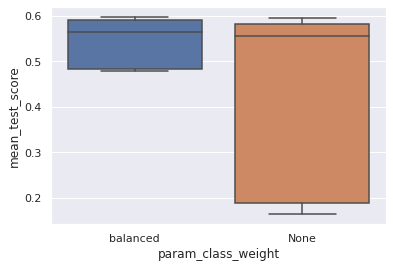

In [37]:
sns.boxplot(x = 'param_class_weight', y = 'mean_test_score', data = rf_cv_results)

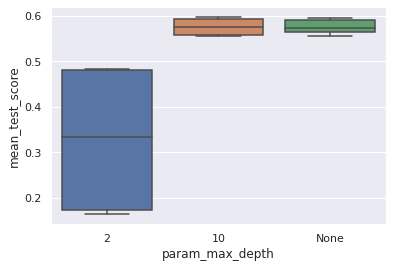

In [38]:
sns.boxplot(x = 'param_max_depth', y = 'mean_test_score', data = rf_cv_results)

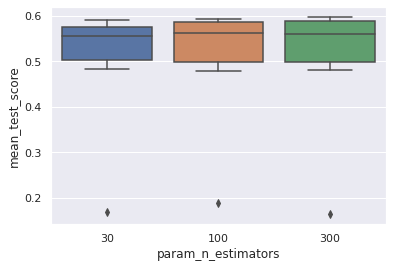

In [39]:
sns.boxplot(x = 'param_n_estimators', y = 'mean_test_score', data = rf_cv_results) # the outliers are the ones with max_depth 2

### 2.4.2. Evaluation

In [40]:
y_pred_rf2 = model_rf2.predict(X_test)
y_pred_prob_rf2 = model_rf2.predict_proba(X_test)

In [41]:
# to calculate accuracy:
accuracy_score(y_test, y_pred_rf2)

0.9033570701932858

In [42]:
# to calculate F1 score:
f1_score(y_test, y_pred_rf2)

0.5957446808510638

In [43]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_rf2, digits = 3))

              precision    recall  f1-score   support

           0      0.967     0.924     0.945     10625
           1      0.509     0.717     0.596      1171

    accuracy                          0.903     11796
   macro avg      0.738     0.821     0.770     11796
weighted avg      0.922     0.903     0.910     11796



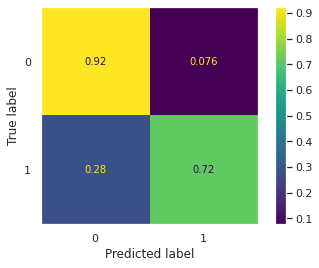

In [44]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_estimator(model_rf2, X_test, y_test, normalize = 'true') 
plt.grid(False)

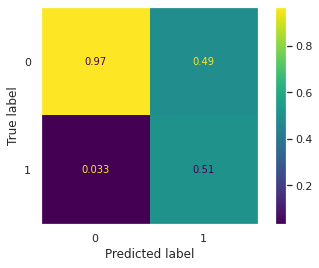

In [45]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_estimator(model_rf2, X_test, y_test, normalize = 'pred')
plt.grid(False)

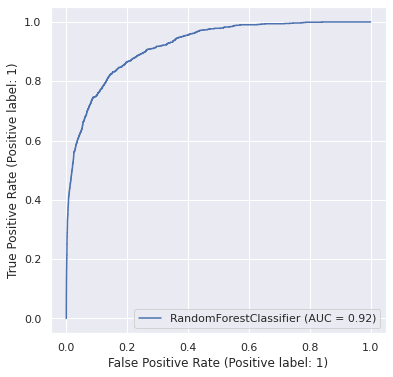

In [46]:
# to plot an ROC:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_rf2, X_test, y_test, ax = ax)

In [47]:
# to calculate Area under ROC:
roc_auc_score(y_test, y_pred_prob_rf2[:,1])

0.9202944090018585

**Some Observations**

* The AUC, accuracy and F1-scores of the untuned and tuned model are comparable. 
* However, the overall recall of the tuned model is remarkably higher (71.7% vs 44.9%). That is because of changing the `class_weight` hyperparameter. 

---

## 2.5. Understanding a Random Forest Model

One major strength of tree-based machine learning models is its inherent ability to easily report **feature importance**. This could be useful to finding insights in the model.

In [48]:
model_rf2_importance = pd.Series(model_rf2.feature_importances_, index = features_list)
model_rf2_importance

GENDER_F                            0.001669
AGE                                 0.061888
LOS                                 0.063390
LOS_ICU                             0.047363
CALLOUT_COUNT_DAY                   0.072474
PRES_COUNT_DAY                      0.051626
PROC_COUNT_DAY                      0.031751
CPT_COUNT_DAY                       0.091681
LAB_COUNT_DAY                       0.201426
INPUTS_CV_COUNT_DAY                 0.071637
INPUTS_MV_COUNT_DAY                 0.028054
OUTPUT_COUNT_DAY                    0.041742
TRANSFER_COUNT_DAY                  0.029640
MICRO_COUNT_DAY                     0.106056
ADMISSION_TYPE_ELECTIVE             0.010868
ADMISSION_TYPE_EMERGENCY            0.033706
ADMISSION_TYPE_NEWBORN              0.010128
ADMISSION_TYPE_URGENT               0.001587
RELIGION_CATHOLIC                   0.001478
RELIGION_NOT SPECIFIED              0.001292
RELIGION_UNOBTAINABLE               0.001953
RELIGION_OTHERS                     0.001545
INSURANCE_

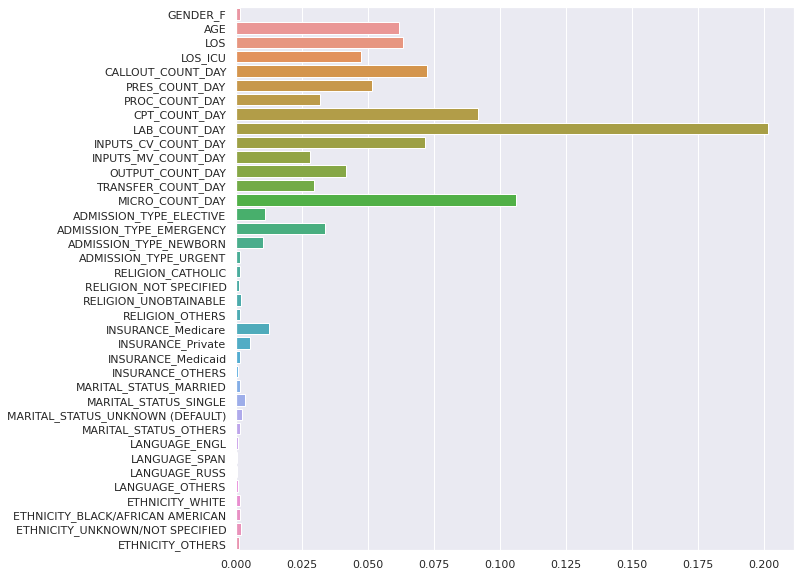

In [49]:
plt.figure(figsize = (10, 10))
sns.barplot(x = model_rf2.feature_importances_, y = features_list)

## 2.6. Saving and Loading your trained model

After training a model you might want to save your model to your Google Drive so that you do not need to re-train it next time. (As a side note, due to the random nature of most machine learning algorithms, if you did not set a `random_state` while training, you would end up with a model with different trained parameters when you re-train a model)

In [50]:
import joblib

To save:

In [51]:
joblib.dump(model_rf2, gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

['/content/gdrive/MyDrive/mimic_in_hosp_mortality_model_rf2.joblib']

To load:

In [52]:
model_rf2_loaded = joblib.load(gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

In [53]:
model_rf2_loaded

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       n_jobs=-1, random_state=1)

## 2.7. Discussion

How well will the models above translate into a decision support system in practice? Here are some issues you may think about (which is beyond the scope of training machine learning models itself):

* What are the purposes or goals of the model? Do they align with the interests and focuses of clinicians, patients or other stakeholders? 
* Suppose we trained a reasonably reliable model. What could be the associated interventions based on the model predictions?
* What are the limitations of the model from an operational perspective? 
  * e.g. consider the time of which the variables becomes available. Could the model deliver the predictions in a timely manner? Can this be improved? 

# References

* [Which machine learning algorithm should I use?](https://blogs.sas.com/content/subconsciousmusings/2020/12/09/machine-learning-algorithm-use/)
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet-2.png)
* [Decision Tree vs. Random Forest – Which Algorithm Should you Use?](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/)
* [Train/Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
